# Visually Impaired  Road Crossing Aid
---
This a report on a project that was developed in a hackathon hosted by [ImplementAI](https://mcgillai.com/implementai-2018). In this report we are going to implement and analyze   the AI mechanism part of the project. This report is divided into the following sections: 

1. **Introduction**
2. **Implementation:** This section contains the preliminary implementations that are taken advantage of in the next section.
3.  **Training:** This section contains our training for the AI agent along with the analysis of our findings.
4.  **Conclusion and Future Work**

# 1. Introduction
Visually impaired  people make up approximately $19\%$ of the world's population. That is approxiamtely **one billion and four hundred thirteen million**  people worldwide. However, technology and its development often forgets such large portion of population, and their needs. We decided to implement an AI based technique  to aid visually impaired  cross the road. In this attempt we are tackling zebra crossings. However, we also have solutions for other scenarios, that we will pursue and study on later dates. The mechanism we implemented for this task can be seen in the following figure:


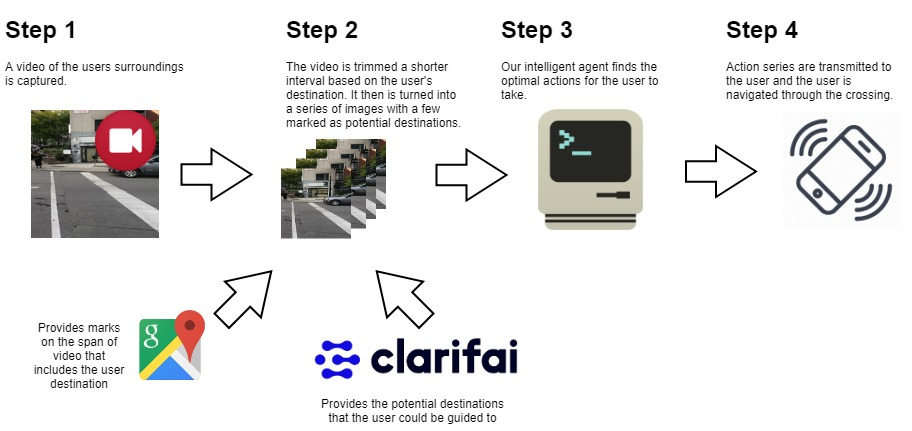

In [12]:
from IPython.display import Image 
Image(filename='diag.jpg')

# 2. Implementation
In this section we are setting up the primary components of our implementation. This section is broken down to the following subsections:


1.   **Dependencies and Data:** In this part we are going to import the needed libraries, and upload the data set. The data set is $15$ images/states that constitute a visual range of the user and a set of states that should be explored.
2.  **Environment Definition:** In this part we are defining the main environment that the reinforcement learning agent will interact with. The environment has $15$ states which comes from a set of $15$ images that constitute the visual range of the user. The action space is composed of $3$ actions, $\{0,1,2\} $ corresponding to **moving to the left**, **pursuing a straight path**, and **moving to the right** respectively. A reward of $-1$ is given for each movement between states and a reward of $+10$ is given upon reaching the goal states. As mentioned before, the set of goal states are indicated beforehand.
3. **Helper Functions:** In this section we develop a few helper functions that will assist us with our analysis and implementation.



## 2.1 Dependencies and Data

In [0]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
!pip install jupyter_contrib_nbextensions

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
imState=np.zeros([15,128,128,3])
for i in range(15):
  imState[i]=plt.imread('{}'.format(i)+'.png')

## 2.2 Environment Definition

In [0]:
class Env:
  #zebra_states: the states that the crossing allined or good for passing 
  
  def __init__(self, current_state, zebra_states):
    self.current_state=current_state
    if self.current_state>14 or current_state<0:
      print("Error, current state needs to be btween 0 and 14")
    self.states=np.zeros([15,1])
    for i in range(zebra_states.size):
      self.states[zebra_states[i]]=1
    
  # Actions: 0, 1, 2 corresponding to left, center and right
  # return the reward
  def action(self,act):
    if act==0 and self.current_state==0:
      return -1
    elif act==1 and self.current_state==0:
      if self.states[self.current_state]==1:
        return 10
      else:
        return -1
    elif act==2 and self.current_state==0:
      self.current_state=self.current_state+1
      if self.states[self.current_state]==1:
        return 10
      else:
        return -1
        
        
    if act==2 and self.current_state==14:
      return -1
    elif act==1 and self.current_state==14:
      if self.states[self.current_state]==1:
        return 10
      else:
        return -1 
    elif act==0 and self.current_state==14:
      self.current_state=self.current_state-1
      if self.states[self.current_state]==1:
        return 10
      else:
        return -1        
    
    if (self.current_state>0 and self.current_state<14):
      if act==0:
        self.current_state=self.current_state-1
        if self.states[self.current_state]==1:
          return 10
        else:
          return -1
        
      if act==2:
        self.current_state=self.current_state+1
        if self.states[self.current_state]==1:
          return 10
        else:
          return -1
        
      if act==1:
        if self.states[self.current_state]==1:
          return 10
        else:
          return -1
  def my_current_state(self):
    return self.current_state
  def isdone(self):
    if self.states[self.current_state]==1:
      return True
    else:
      return False

## 2.3 Helper Functions
We are defining $3$ helper functions in this section. Here is a short summary on their behavior:

* **`random_action_generator():`** This function generates a random action, an integer number between $\{0,1,2\}$.
* ** `action3_softmax(x,theta):`** This function returns an array that associates  a learned probability distribution to the action space. The parameter `theta` is learned parameter influencing the action selection process. The parameter `x` represents the state at which an action should be taken.
* **`choos_action(x):`** This function chooses an action from the three available actions, $\{0,1,2\}$ with at random under a non-uniform probability distribution setting. The non-uniform probability distribution is given by the parameter `x`.

In [0]:
def random_action_generator():
  return np.random.randint(3, size=1)[0]

In [0]:
def action3_softmax(x,theta):
  act0=np.exp(np.dot(np.append(x,np.array([1,0,0])),theta))
  act1=np.exp(np.dot(np.append(x,np.array([0,1,0])),theta))
  act2=np.exp(np.dot(np.append(x,np.array([0,0,1])),theta))
  act_sum=act0+act1+act2
  softmax_return=np.array([act0/act_sum,act1/act_sum,act2/act_sum])
  return softmax_return

In [0]:
def choos_action(x):
  y=np.zeros(x.size)
  a=random.random()
  for i in range(x.size):
    y[i]=np.sum(x[:i+1])
    if a<=y[i]:
      return i
    

# 3. Training
This section is dedicated to training an intelligent model for the task at hand. This section has $2$ main subsections:


1.   **Random Model:** In this part we will test our environment on an agent with a random policy i.e. taking actions at random. This will constitute a baseline for our intelligent agent to be compared with.
2.   **Reinforcement Learning Agent:** In this part we will train a reinforcement learning agent on our environment using policy gradient methods. We will compare the agent performance against the baseline and the most optimal behavior.



## 3.1 Random Mode
In this section we are aiming to constitute a baseline for the study of our intelligent agent through a study on a random policy agent. In the code below we will let the random policy agent to explore the environment for $1000$ episodes. We repeat this process $10$ times and average over this $10$ attempts to find a more smooth representation of the random policy agent's behavior. <br> As another source of insight we will also average  over the entire $10,000$ runs and report a finial performance for the random policy agent. The comments and analysis in this section are based on the followings and are presented in the discussion section (**3.1.3 Discussion**):


1.   **Average Accumulated Reward**
2.   **Average Accuracy**





In [0]:

number_trials=1000
avg_random_reward=np.zeros(number_trials)
#avg over 10 times

for i_episode in range(1000):
  random_result=0
  for k in range(10):
    env=Env(0,np.array([7,8,9]))
    observation = env.my_current_state()
    for t in range(20):
      action = random_action_generator()
      reward = env.action(action)
      obs=env.my_current_state()
      random_result+=reward
      if env.isdone():
        break
  avg_random_reward[i_episode]=random_result/10

### 3.1.1 Average Accumulated Reward

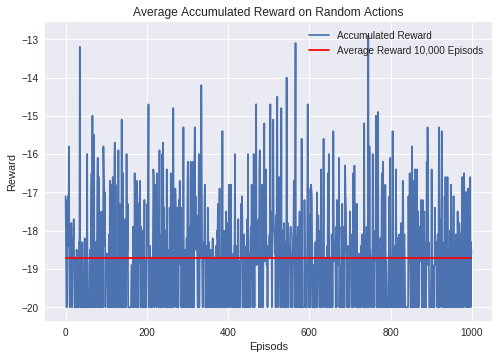

The average reward over 10,000 random episods is:  -18.7097


In [138]:
avg10000trials=np.zeros(number_trials)+np.average(avg_random_reward)
plt.plot(avg_random_reward, label='Accumulated Reward')
plt.plot(avg10000trials, label='Average Reward 10,000 Episods',color='red')
plt.title("Average Accumulated Reward on Random Actions")
plt.xlabel("Episods")
plt.ylabel('Reward')    
plt.legend()
plt.show()
print("The average reward over 10,000 random episods is: ",avg10000trials[0])

### 3.1.2 Average Percent Accuracy


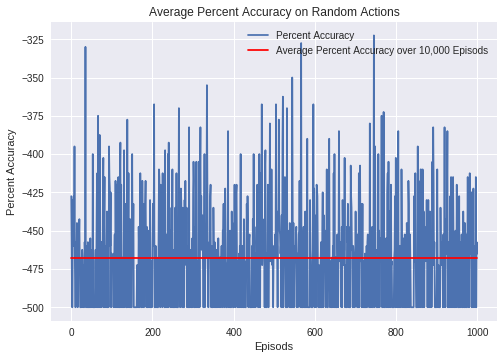

The average percent accuracy over 10,000 random episods is:  -467.74250000000006


In [156]:
avg10000trials=np.zeros(number_trials)+np.average(avg_random_reward)
plt.plot((1-((4-avg_random_reward)/4))*100, label='Percent Accuracy')
plt.plot((1-((4-avg10000trials)/4))*100, label='Average Percent Accuracy over 10,000 Episods',color='red')
plt.title("Average Percent Accuracy on Random Actions")
plt.xlabel("Episods")
plt.ylabel('Percent Accuracy')    
plt.legend()
plt.show()
print("The average percent accuracy over 10,000 random episods is: ",(1-((4-avg10000trials[0])/4))*100)

### 3.1.3 Discussion
In the previous two sections we are presenting two plots, one on the average accumulated rewards of the random policy agent and the other on its percentage of accuracy. A good baseline for our future comparisons would be the average behavior of the agent over the entire $10,000$ trials. We can see that the random policy agent scores the followings:

**Average Accumulated Reward** | **Percentage of Accuracy**
---|---
$-18.7097$ | $ -467.74\%$



## 3.2 Reinforcement Learning Agent
In this section we will implement our learning algorithm. The reinforcement learning algorithm we chose for this model is a policy gradient method. Specifically we are training our agent on an actor-critic method with eligibility traces. The algorithm we implemented for this agent can be found in [Sattun and Barto](http://incompleteideas.net/book/the-book-2nd.html) page $274$. 

*   The actor is defined as:$$\pi(a|s,\theta)=softmax(h(s,a,\theta))$$
Where $h$ is the parameterized numerical preferences for each state-action pair. We define $h$ to be:
$$\theta^Tx(s,a)$$
Meaning that we define our preferences to be linear in features. Where the feature vector $x$ is simply given by:
$$[1,s,1,0,0]$$ $$[1,s,0,1,0]$$ $$[1,s,0,0,1]$$
For action 0, 1, 2, 3 respectively. The parameter $s$ here indicates the position of the character in the ForzenLake world. Note that under this definition we have:
$$\nabla_\theta\mathrm{ln}\pi(a|s,\theta)=x(s,a)-\sum_b\pi(b|s,\theta)x(s,b)$$
*   The critic function $\hat{v}(s,w)$ is given by $w^Tx(s)$ where $x(s)$ is the degree 1 polynomial feature of state $s$ and since each state in this problem is presented by a single number indicating the location of that state, we have: $$x(s)=[1,s]$$. Note that in this definition we have: $$\nabla_w\hat{v}(s,a)=x(s)$$


The function presented below, 
* `actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)`

is based on the algorithm in [Sattun and Barto](http://incompleteideas.net/book/the-book-2nd.html) page $274$. It runs the algorithm for one episode of the problem and then returns the parameters $\theta$ and $w$ at the end of that episode along with the accumulated rewards of the episode.

In [0]:
def actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w):
  total_reward=0
  env=Env(0,np.array([7,8,9]))
  observation_old = env.my_current_state()
  #print("Current State is: ", observation_old,'\n')
  plt.grid('off')
  plt.axis('off')
  plt.imshow(imState[observation_old])
  plt.title('Current State')
  plt.show()
  
  
  
  z_theta=np.zeros(theta.size)
  z_w=np.zeros(w.size)
  I=1
  for t in range(200):
    x_old=np.append(1,observation_old)    
    action=choos_action(action3_softmax(x_old,theta))
    if action==0:
      action_f=np.array([1,0,0])
      print("Action: Please move to the left",'\n')  
    if action==1:
      action_f=np.array([0,1,0])
      print("Action: Please stay in this direction to the right",'\n')
    if action==2:
      action_f=np.array([0,0,1])
      print("Action: Please move to the right",'\n')
      

    reward = env.action(action)
    print('The reward received beacause of this action is: ', reward, '\n')
    
    observation_new=env.my_current_state()
    #print('This action brough us to the state: ',observation_new,'\n')
    plt.grid('off')
    plt.axis('off')
    plt.imshow(imState[observation_old])
    plt.title('The State Reached Due to The Action')
    plt.show()
    
    done=env.isdone()
    print('Is the agent set to go? ',done,'\n\n' )
    total_reward=total_reward+reward
    x_new=np.append(1,observation_new)
    if done:
      delta=reward-np.dot(x_old,w)
    else:
      delta=reward+gamma*(np.dot(x_new,w))-np.dot(x_old,w)
    z_w=gamma*lambda_w*z_w+I*x_old
    z_theta=gamma*lambda_theta*z_theta+I*(np.append(x_old,action_f)-action3_softmax(x_old,theta)[0]*np.append(x_old,np.array([1,0,0]))
                                          -action3_softmax(x_old,theta)[1]*np.append(x_old,np.array([0,1,0]))
                                         -action3_softmax(x_old,theta)[2]*np.append(x_old,np.array([0,0,1])))
    w = w+alpha_w*delta*z_w
    theta=theta+alpha_theta*delta*z_theta
    I=gamma*I
    observation_old=observation_new
    if done:
      #print("Episode finished after {} timesteps".format(t+1))
      break
  return theta,w,total_reward

  We are training our agent for $200,000$ episodes and record its accumulated rewards for each episode  along with the percentage of its accuracy. 

In [200]:
gamma=np.array([0.5])
lambda_theta=np.array([0.5])
lambda_w=lambda_theta
alpha_theta=2**-9
alpha_w=2**-6
number_of_episods=200000
number_of_runs_for_average=1
average_success_v0=np.zeros([number_of_runs_for_average,number_of_episods])
g=0
l=g
for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  #t_r=0 
  theta=np.zeros(5)
  w=np.zeros(2)
  for i in range(number_of_episods):
    theta,w,temp=actor_critic_F(gamma[g],lambda_theta[l],lambda_w[l],alpha_theta,alpha_w,theta,w)
    average_success_v0[n,i]=temp

processing:  100.0 % of the work


### 3.2.1 Accumulated Reward Per Episode

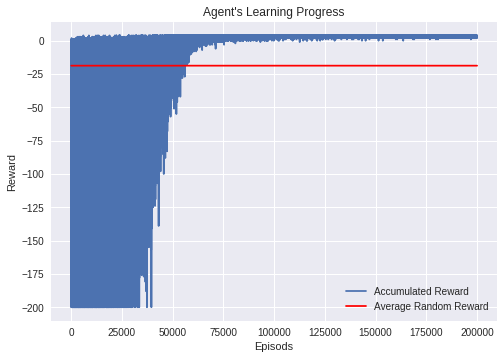

Agent's best reward is:  4.0


In [201]:
plt.plot(average_success_v0.flatten(), label='Accumulated Reward')
plt.plot(avg200000trials, label='Average Random Reward',color='red')
plt.title("Agent's Learning Progress")
plt.xlabel("Episods")
plt.ylabel('Reward')    
plt.legend()
plt.show()
print("Agent's best reward is: ", average_success_v0.flatten()[-1])

### 3.2.2 Percentage Accuracy of The Agent

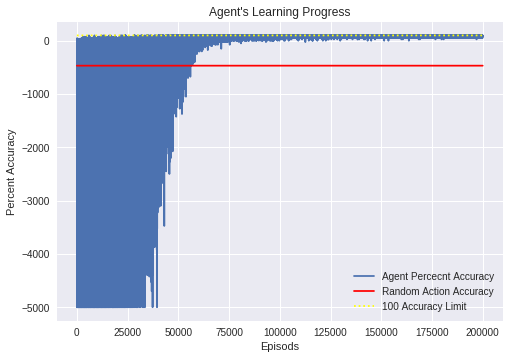

Agent's best percecnt accuracy is:  100.0


In [203]:
best_accuracy=np.zeros(200000)+100
plt.plot((1-((4-average_success_v0.flatten())/4))*100, label='Agent Percecnt Accuracy')
plt.plot((1-((4-avg200000trials)/4))*100, label='Random Action Accuracy',color='red')
plt.plot(best_accuracy, ":", label='100 Accuracy Limit',color='yellow')
plt.title("Agent's Learning Progress")
plt.xlabel("Episods")
plt.ylabel('Percent Accuracy')    
plt.legend()
plt.show()
print("Agent's best percecnt accuracy is: ", ((1-((4-average_success_v0.flatten()[-1])/4))*100))

### 3.2.3 Trained Agent Behavior
The following shows the behavior of our trained agent. We can investigate its perception of the environment, the actions it decides to take, rewards it receives and whether or not its has finished guiding the user to the right pass.


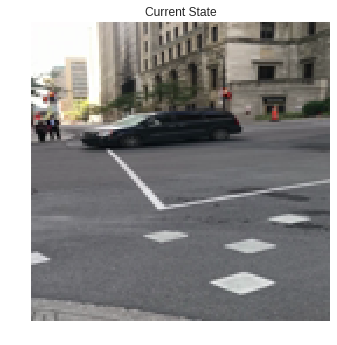

Action: Please move to the right 

The reward received beacause of this action is:  -1 



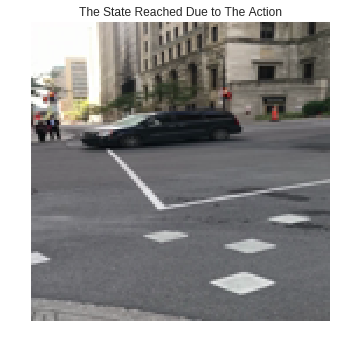

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  -1 



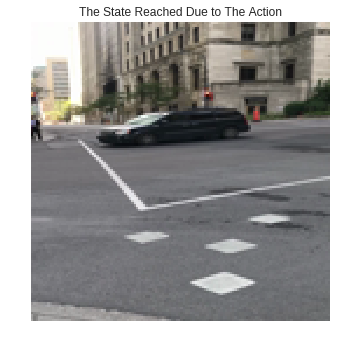

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  -1 



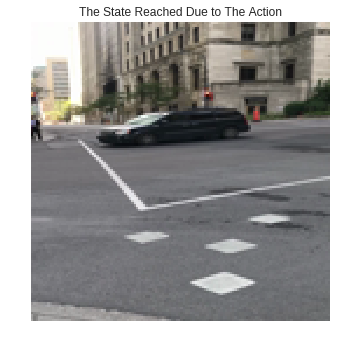

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  -1 



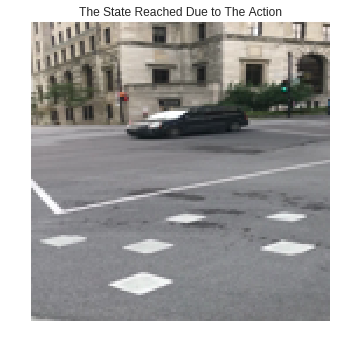

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  -1 



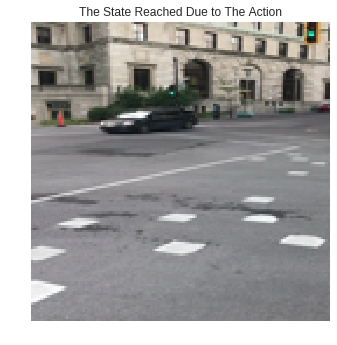

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  -1 



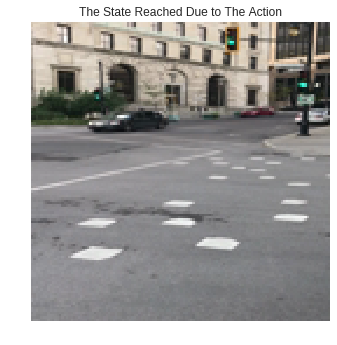

Is the agent set to go?  False 


Action: Please move to the right 

The reward received beacause of this action is:  10 



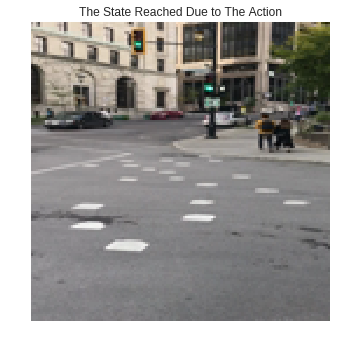

Is the agent set to go?  True 




In [211]:
a=actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w)

### 3.2.4 Discussion
The graphs in the sections (**3.2.1** and **3.2.2**) demonstrate the learning process of our reinforcement learning agent. Following these graphs we can see that the accuracy and the rewards collected per episode by the agent are both increasing with more training and adjustment of the parameters. The agent reaches a $100\%$ accuracy in comparison to the optimal behavior around $100,000^{th}$ episode of training although we continued the training for $200,000$ episodes. In section (**3.2.3**)  we can visually inspect the result of the actions our agent is taking. We can see the optimal set of action it has chosen as well as a view of its environment.

# 4. Conclusion and Future Work
In conclusion, we can see that our intelligent agent has learned the optimal behavior for its task here and performs with $100%$ accuracy in comparison to the absolute optimal behavior. However, this does not mean that there is no room for improvement. The main task at hand here was navigation, and we achieved it through function approximation using linear features. For our purposes the linear features were enough and worked very well, however one could implement a more sophisticated function approximation mechanism such as deep models.<br>
<br>
The other issue we would like to improve upon is the computation time so that the computations could be done online and in real time. 